In [1]:
'''
import sd19 png image & label and save python npz file
reference： http://mxnet.io/tutorials/python/mnist.html
nparray+np.savez_compressed("t.npz", train_img=train_img) 
*read data from  /home/jmguo121/jm/MNIST_data/by_class/

mxnet預設分類是從0開始設起，label0-9或0-62等

np.vstack-->label(train_lbl, val_lbl) is int  -->to avoid, ValueError: could not convert string to float: 'J'

labels is --> 37-> 7
(
/by_class.zip係以hexadecimal ASCII representations命名影像資料夾，如4a-j,4b-k,30-0
37-> 7
/home/jmguo121/jm/MNIST_data/by_class/37/train_37/train_37_00505.png
)

image size=128x128

Training vs validation
/37/->77,704 個項目，大小為 51.0 MB; 
/37/train_37/ -->35,796 個項目，大小為 21.2 MB  ;;the suggested training set for OCR studies
37/hsf_4  --> 6,097 個項目，大小為 3.5 MB  ;; as a standard testing results reporting set
Training vs validation ，6 vs 1
mnist train data total：60000
(
The train_30 files contains the “0”s of all writers of partitions hsf_{0,1,2,3,6,7}. The
train_?? files comprise the suggested training set for OCR studies. The hsf_4 is likewise
earmarked as a standard testing results reporting set. Note that the class files are redundant
in this tree, since they contain only one unique hexadecimal class string, and the class has
already been indicated in the parent directory name. 
)

#train.npz,val.npz儲存影像,label,image mode & size 
*待改善
**原mnist的資料類是random排列如label: [5 0 4 1 9 2 1 3 1 4]
**目前程式sd19同一類都在一起，也要改--〉label: [7 7 7 7 7 7 7 7 7 7]
'''
from glob import glob
from os.path import splitext
from PIL import Image

import numpy as np
import os
import urllib
import gzip
import struct
import matplotlib.pyplot as plt
import time

tStart = time.time()#計時開始

dataPath='/home/jmguo121/jm/MNIST_data/sd19_by_class/'   #sd-19 data path
#image(PngImageFile mode=RGB size=128x128 (0, 255))  resized into 28x28 with grayscale value between 0 and 254
rows, cols = 28, 28

def prepareData(dataPath,rows, cols):
        #將sd-19之train_,hsf_4資料夾png分別讀至一np array並存成壓縮檔sd-19train,sd-19val 
    train_img = np.zeros((rows, cols), dtype=np.float32)  #traning image for save npz file       
    train_lbl= np.zeros(1, dtype=np.int8)  #training label
    val_img= np.zeros((rows, cols), dtype=np.float32)   #validation image for save npz file 
    val_lbl= np.zeros(1, dtype=np.uint8)    #validation label 

    def rgb2gray(rgb):  #png 3chanel-> gray 1chanel
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b  #sd19白底黑字的二值(254.975,0)影像28*28，floating
        #gray = abs(int(0.2989 * r + 0.5870 * g + 0.1140 * b))  #改成同mnist,黑底灰字影像28*28，int
        return gray  
    
    #如果png影像之npz已存在
    try:
        data = np.load("train.npz") 
        train_img, train_lbl = data['train_img'], data['train_lbl'] 
        data = np.load("val.npz")
        val_img, val_lbl = data['val_img'], data['val_lbl'] 
        if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
            printprint("+npz壓縮檔有問題，將由sd19_by_clas夾讀取，並製作npz file")  
        else:  
            print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img:'+str(len(val_img)))
            return train_img, train_lbl, val_img, val_lbl
    except: 
        print("npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file")   
    

        #creat np array of image and label
    
    i=0  
    pnglist = glob( dataPath+"*/train*/*.png" )   #the suggested training set for OCR studie
    for png in pnglist: 
        i +=1 
        if((i%8)==0):  #原有731668張，每8張取一個
            #if "train" in png:  #the suggested training set for OCR studies
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2) 
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel 
            train_img=np.vstack((train_img,im2))  #is need:(( ));im2 加在 train_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'   
            #train_lbl = np.vstack((train_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G';;training label
            train_lbl = np.append(train_lbl, int(i1, 16)) #training label;i1 加在train_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            if((i%500)==0):
                print('約已讀取：'+ str(int(i/5)) +'---'+png[len(dataPath):len(png)]+'\r',end='')

    pnglist = glob( dataPath+"*/hsf_4/*.png" )  #validation data; hsf_4 standard testing set
    for png in pnglist:
        i +=1 
        if((i%8)==0): #原有82587，每8個取一個
            #elif "hsf_4" in png:    #validation data; hsf_4 standard testing set
            im1=Image.open(png) 
            im2 = im1.resize((rows, cols), Image.NEAREST)      # use nearest neighbour filter to resize the image(28*28)
            im2=np.array(im2)
            im2=rgb2gray(im2)  #png 3chanel-> gray 1chanel
            val_img=np.vstack((val_img,im2))  #validation image;im2加在val_img後面
            i1=png[len(dataPath):len(dataPath)+2] #取出label like '47'    
            #val_lbl = np.vstack((val_lbl, chr(int(i1, 16))))  #16進位'47' --> 'G'
            val_lbl = np.append(val_lbl, int(i1, 16)) #validation label;i1加在val_lbl後面;16進位'47'(string) 代表'G'--> 轉成10進位的71,chr(71)-->'G'
            if((i%500)==0):
                print('約已讀取：'+ str(int(i/5)) +'---'+png[len(dataPath):len(png)]+'\r',end='')
 
    if train_img==[] or train_lbl==[] or val_img==[] or val_lbl==[]:
        print("無資料")
        return 0
    #儲存影像,label,image mode & size
    print(len(train_lbl),train_lbl.shape, len(train_img),train_img.shape)
    #im={'mode':im2.mode,'size':im2.size}
    train_img=train_img.reshape((len(train_lbl),28, 28))
    train_img=np.delete(train_img, 0,0)  #del 空的初值
    train_lbl=np.delete(train_lbl, 0,0)  #del 空的初值
    val_img=val_img.reshape((len(val_lbl),28, 28))
    val_img=np.delete(val_img, 0,0)  #del 空的初值
    val_lbl=np.delete(val_lbl, 0,0)  #del 空的初值
    
    #mxnet label要從0開始起，-48,48-57(0-9)-->0-9,65-122(a-z)-->10-67
    train_lbl=np.array([x-48 if x < 59 else x-65+10 for x in train_lbl])
    val_lbl=np.array([x-48 if x < 59 else x-65+10 for x in val_lbl])
    #abs(val_img-254)-->改成同mnist,黑底灰字影像28*28，int;
    train_img=np.int_(abs(train_img-254))
    val_img=np.int_(abs(val_img-254))    
    
    np.savez_compressed("train.npz", train_img=train_img, train_lbl=train_lbl)    
    np.savez_compressed("val.npz", val_img=val_img, val_lbl=val_lbl) 
    #np.savez_compressed("train.npz", train_img=np.int_(abs(train_img-254)), train_lbl= np.int8(train_lbl))
    #np.savez_compressed("val.npz", val_img=np.int_(abs(val_img-254)), val_lbl=np.int8(val_lbl))
    print('成功讀取npz file, training image：'+ str(len(train_img))+', val_img1:'+str(len(val_img)))
    return train_img, train_lbl, val_img, val_lbl #sd19白底黑字的二值(254.975,0)影像28*28，floatin 
    #return np.int_(abs(train_img-254)), np.int8(train_lbl), np.int_(abs(val_img-254)), np.int8(val_lbl)   

#將sd19之png images、labe、image mode & size等匯集成list
train_img, train_lbl, val_img, val_lbl = prepareData(dataPath, rows, cols) 
   
tEnd = time.time()#計時結束
m, s = divmod((tEnd - tStart), 60)  
h, m = divmod(m, 60) 
print('')
print ("it cost: %02d:%02d:%02d" % (h, m, s)) 

npz壓縮檔不存在，將由sd19_by_clas夾讀取，並製作npz file


/home/jmguo121/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:120: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


91459 (91459,) 2560852 (2560852, 28)
成功讀取npz file, training image：91458, val_img1:10323

it cost: 01:06:34


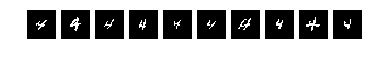

label: [4 4 4 4 4 4 4 4 4 4]
<class 'numpy.ndarray'> <class 'numpy.int64'> (91458,) [7 7 7 7 7 7 7 7 7 7]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[8000+i], cmap='Greys_r')
    plt.axis('off')
plt.show()
#mxnet預設分類是從0開始設起，label0-9或0-62等
#所以如要用ascii表示還再加(0-9)48，chr(0+48)-->0;(a-z)+65
print('label: %s' % (train_lbl[8000:8010],))
print(type(train_lbl),type(train_lbl[0]), train_lbl.shape,train_lbl[0:10])

In [3]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)


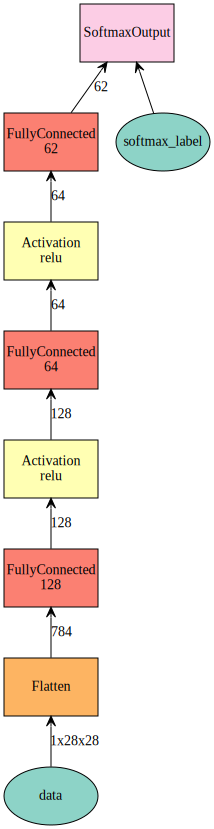

In [4]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=1*128) #原128
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 1*64)  #ya 64
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=62)  #num_hidden=10
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [6]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 20,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 1*200) # 原為200,output progress for each 200 data batches
)

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 2295.40 samples/sec	Train-accuracy=0.049250
INFO:root:Epoch[0] Batch [400]	Speed: 2161.64 samples/sec	Train-accuracy=0.052250
INFO:root:Epoch[0] Batch [600]	Speed: 2509.76 samples/sec	Train-accuracy=0.048000
INFO:root:Epoch[0] Batch [800]	Speed: 2926.79 samples/sec	Train-accuracy=0.053300
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=36.614
INFO:root:Epoch[0] Validation-accuracy=0.107981
INFO:root:Epoch[1] Batch [200]	Speed: 3066.10 samples/sec	Train-accuracy=0.083150
INFO:root:Epoch[1] Batch [400]	Speed: 2348.51 samples/sec	Train-accuracy=0.094350
INFO:root:Epoch[1] Batch [600]	Speed: 2205.49 samples/sec	Train-accuracy=0.120050
INFO:root:Epoch[1] Batch [800]	Speed: 2245.76 samples/sec	Train-accuracy=0.173400
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=38.105
INFO:root:Epoch[1] Validation-accuracy=0.255769
INFO:root:Epoch[2] Batch [200]	Speed: 3394.34 samples/sec	Train-accuracy=0.218000
INFO:roo

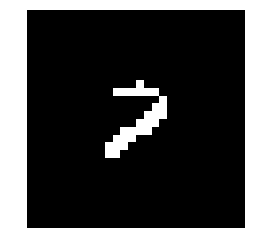

Classified as 1 with probability 0.053962



<ipython-input-7-729861b23942>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(max(prob) > 0.99, "Low prediction accuracy.")


In [7]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
plt.imshow(val_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()
prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]
assert(max(prob) > 0.99, "Low prediction accuracy.")
print('Classified as %d with probability %f' % (prob.argmax(), max(prob)))
print(chr(val_lbl[0]))

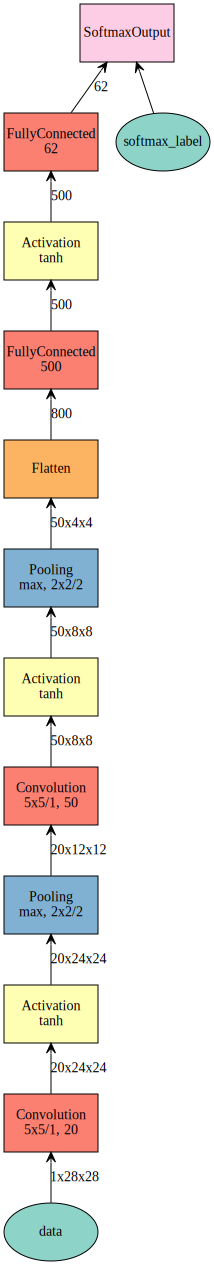

In [9]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=1*20)  #原為20
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=1*50) 
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=1*500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=62)  #原為 num_hidden=10
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
#mx.viz.plot_network(symbol=lenet, shape=shape)

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}  #原程式漏列這行
mx.viz.plot_network(symbol=lenet, shape=shape)

In [10]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
#mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(    
    #ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 1*200))  #原為200
 
assert(model.score(val_iter) > 0.98, "Low validation accuracy.")

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 364.62 samples/sec	Train-accuracy=0.048950
INFO:root:Epoch[0] Batch [400]	Speed: 354.50 samples/sec	Train-accuracy=0.049650
INFO:root:Epoch[0] Batch [600]	Speed: 353.50 samples/sec	Train-accuracy=0.046150
INFO:root:Epoch[0] Batch [800]	Speed: 351.63 samples/sec	Train-accuracy=0.048450
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=257.947
INFO:root:Epoch[0] Validation-accuracy=0.080000
INFO:root:Epoch[1] Batch [200]	Speed: 355.58 samples/sec	Train-accuracy=0.045700
INFO:root:Epoch[1] Batch [400]	Speed: 350.17 samples/sec	Train-accuracy=0.047100
INFO:root:Epoch[1] Batch [600]	Speed: 353.38 samples/sec	Train-accuracy=0.044750
INFO:root:Epoch[1] Batch [800]	Speed: 349.94 samples/sec	Train-accuracy=0.049200
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=260.857
INFO:root:Epoch[1] Validation-accuracy=0.080385
INFO:root:Epoch[2] Batch [200]	Speed: 348.42 samples/sec	Train-accuracy=0.182700
INFO:root:Epoch

In [ ]:
print(1)